original code: https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, \
                             AdaBoostClassifier,\
                             GradientBoostingClassifier, \
                             ExtraTreesClassifier, \
                             VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, \
                                    cross_val_score, \
                                    StratifiedKFold, \
                                    learning_curve

sns.set(style='white', context='notebook', palette='deep')

## Load and check data

In [3]:
#Load train and test set
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
IDtest = test["PassengerId"]

In [4]:
#Outlier detection
def detectOutLiers(df, n, features):
    """
    Take a dataframe of features.
    Return a list of the indices corresponding to the observations
    containing more than 'n' outliers according to the Tukey method.
    """
    outlierIndices=list()
    
    #iterate over features(columns)
    for col in features:
        Q1 = np.percentile(df[col], 25) #1st quartile(25%)
        Q3 = np.percentile(df[col], 75) #3rd quartile(75%)
        IQR = Q3 - Q1 #Interquartile range (IQR)
        
        outlierStep = 1.5 * IQR
        
        outlierListCol = df[(df[col]<Q1-outlierStep) | (df[col]>Q3+outlierStep)].index
        
        outlierIndices.extend(outlierListCol)
    
    outlierIndices = Counter(outlierIndices)
    multipleOutLiers = list(k for k,v in outlierIndices.items() if v>n)
    
    return multipleOutLiers

outliersDrop = detectOutLiers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

In [5]:
train.loc[outliersDrop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [6]:
#Drop outliers
train = train.drop(outliersDrop, axis = 0).reset_index(drop=True)

In [7]:
#Join train and test set: This hleps to obtain the same number of features
#                         during categorial conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [8]:
#Check null and missing values
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [9]:
#Check null and missing values from train
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
#Check train data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## Feature analysis

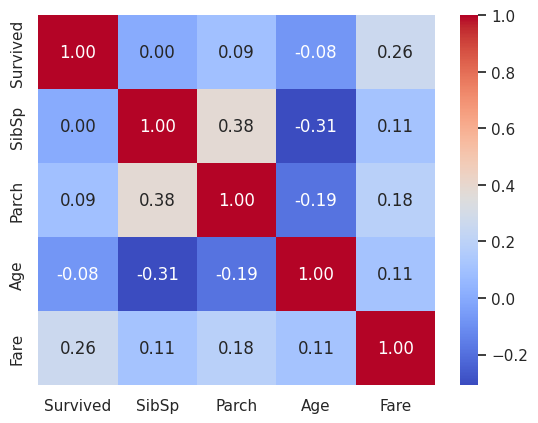

In [12]:
#Numerical values
#Visualize 'SibSp', 'Parch', 'Age', and 'Fare'
#Using correlation matrix
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

Text(0, 0.5, 'survival probability')

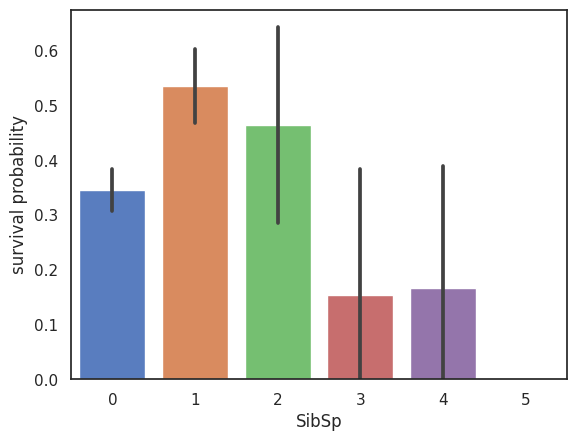

In [13]:
#Visualize the feature 'SibSP'
g = sns.barplot(x='SibSp', y='Survived', data=train, palette='muted')
g.set_ylabel('survival probability')

Text(0, 0.5, 'survival probability')

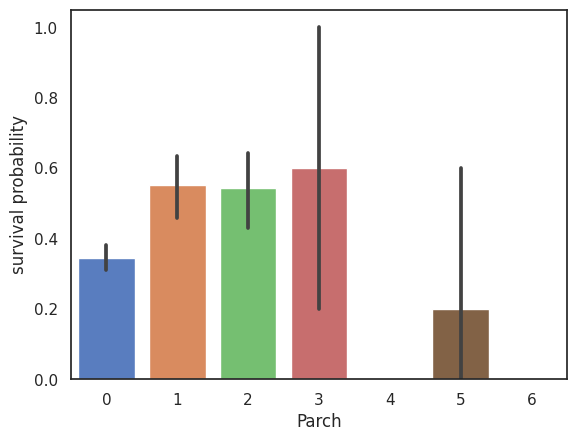

In [14]:
#Visualize the feature 'Parch'
g = sns.barplot(x='Parch', y='Survived', data=train, palette='muted')
g.set_ylabel('survival probability')

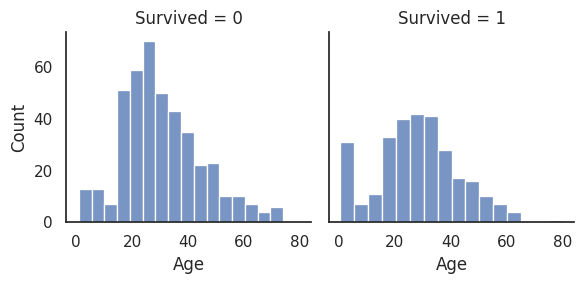

In [15]:
#Visualize the feature 'Age'
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.histplot,'Age')

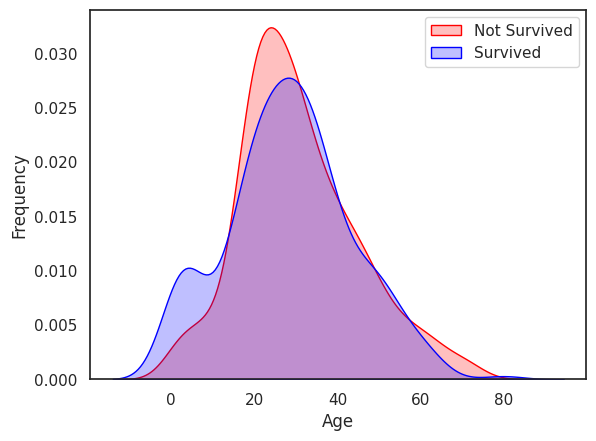

In [16]:
#Visualize the feature 'Age'
g = sns.kdeplot(train['Age'][(train['Survived']==0)&(train['Age'].notnull())], \
                color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1)&(train['Age'].notnull())], \
               ax=g, color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

In [17]:
#Analyze the feature 'Fare': check null data
dataset['Fare'].isnull().sum()

1

In [18]:
#Analyze the feature 'Fare': fill the null data with the median value
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

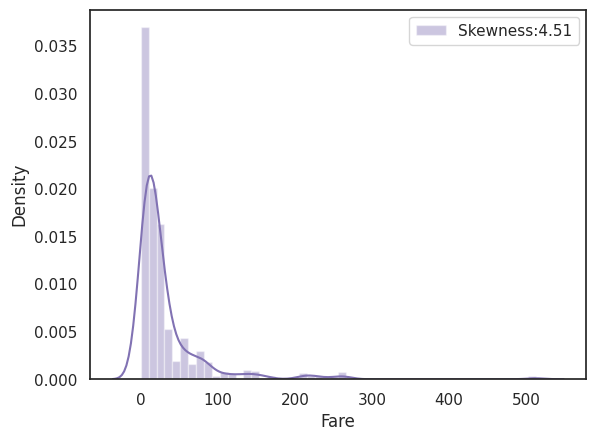

In [19]:
#Visualize the feature 'Fare'
g = sns.distplot(dataset['Fare'], color='m', label=f"Skewness:{dataset['Fare'].skew():.2f}")
g = g.legend(loc='best')

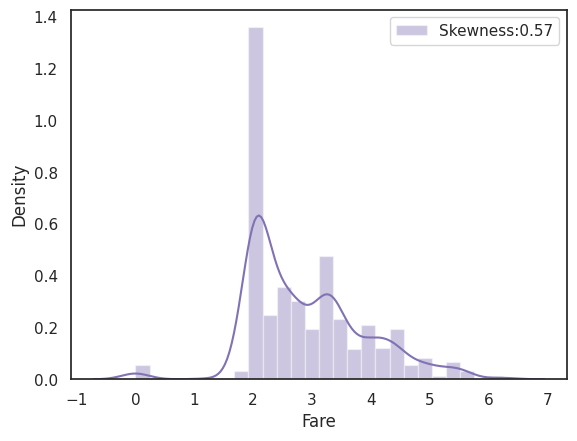

In [20]:
#Analyze the feature 'Fare': fix the skewness -> logarithm
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)
g = sns.distplot(dataset['Fare'], color='m', label=f"Skewness:{dataset['Fare'].skew():.2f}")
g = g.legend(loc='best')

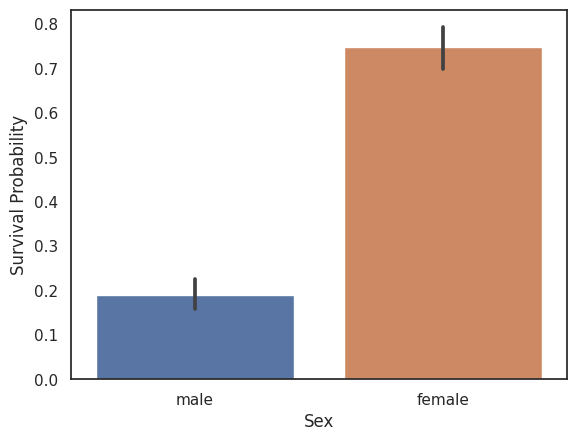

In [21]:
#Visualize the feature 'Sex'
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [22]:
#Analyze the feature 'Sex': check the mean value
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


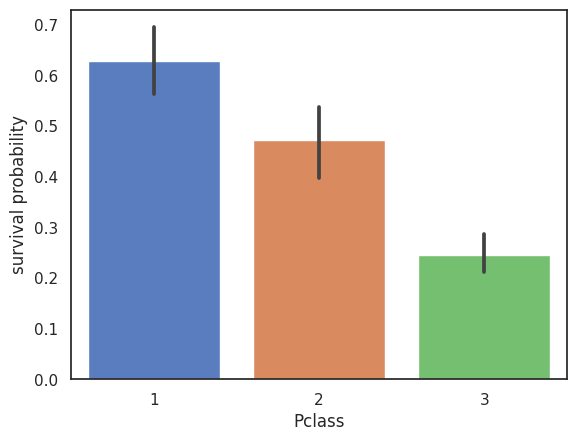

In [23]:
#Visualize the feature 'Pclass'
g = sns.barplot(x='Pclass', y='Survived', data=train, palette='muted')
g = g.set_ylabel('survival probability')

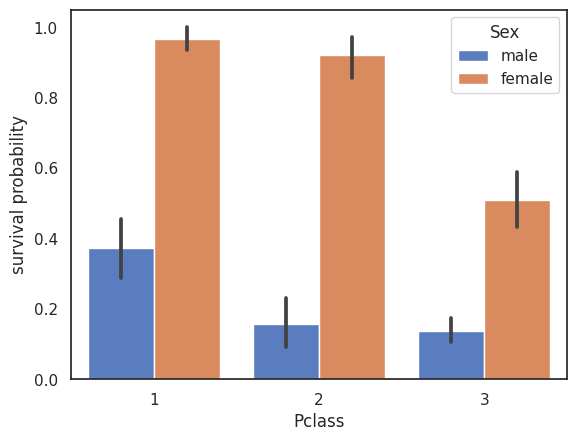

In [24]:
#Compare the featuers: 'Sex', 'Pclass'
g = sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train, palette='muted')
g = g.set_ylabel('survival probability')

In [25]:
#Analyze the feature 'Embarked': check null data
dataset["Embarked"].isnull().sum()

2

In [26]:
#Analyze the feature 'Fare': fill the null data with the 'S', the most frequent value
dataset['Embarked'] = dataset['Embarked'].fillna('S')

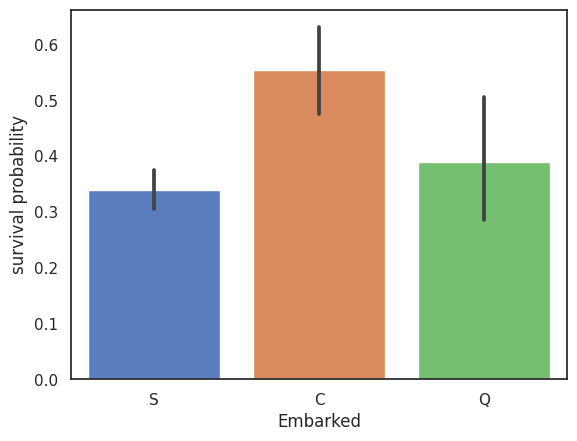

In [27]:
#Visualize the feature 'Embarked'
g = sns.barplot(x='Embarked', y='Survived', data=train, palette='muted')
g = g.set_ylabel('survival probability')

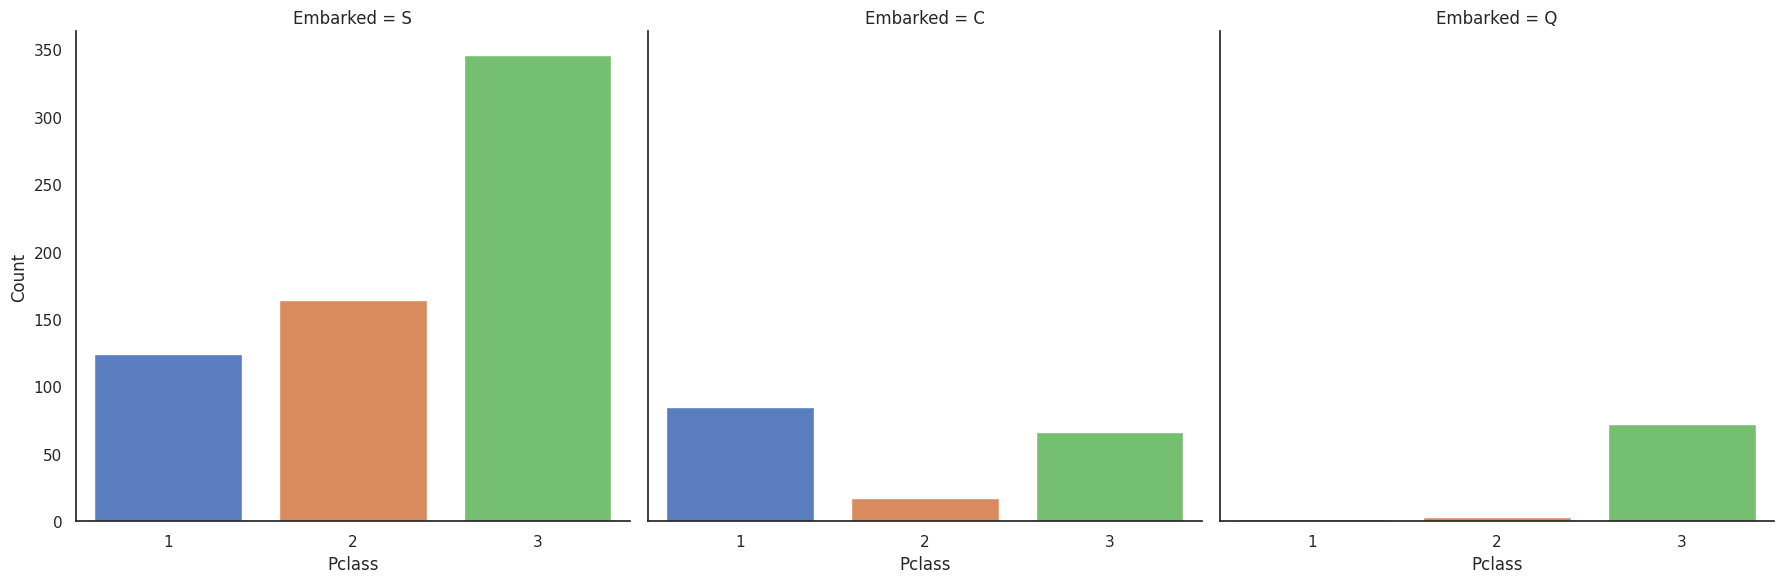

In [28]:
#Compare the features: 'Pclass', 'Embarked'
g = sns.catplot(x="Pclass", col="Embarked", data=train, height=6, kind="count", palette="muted")
g = g.set_ylabels("Count")

## Filling the missing values

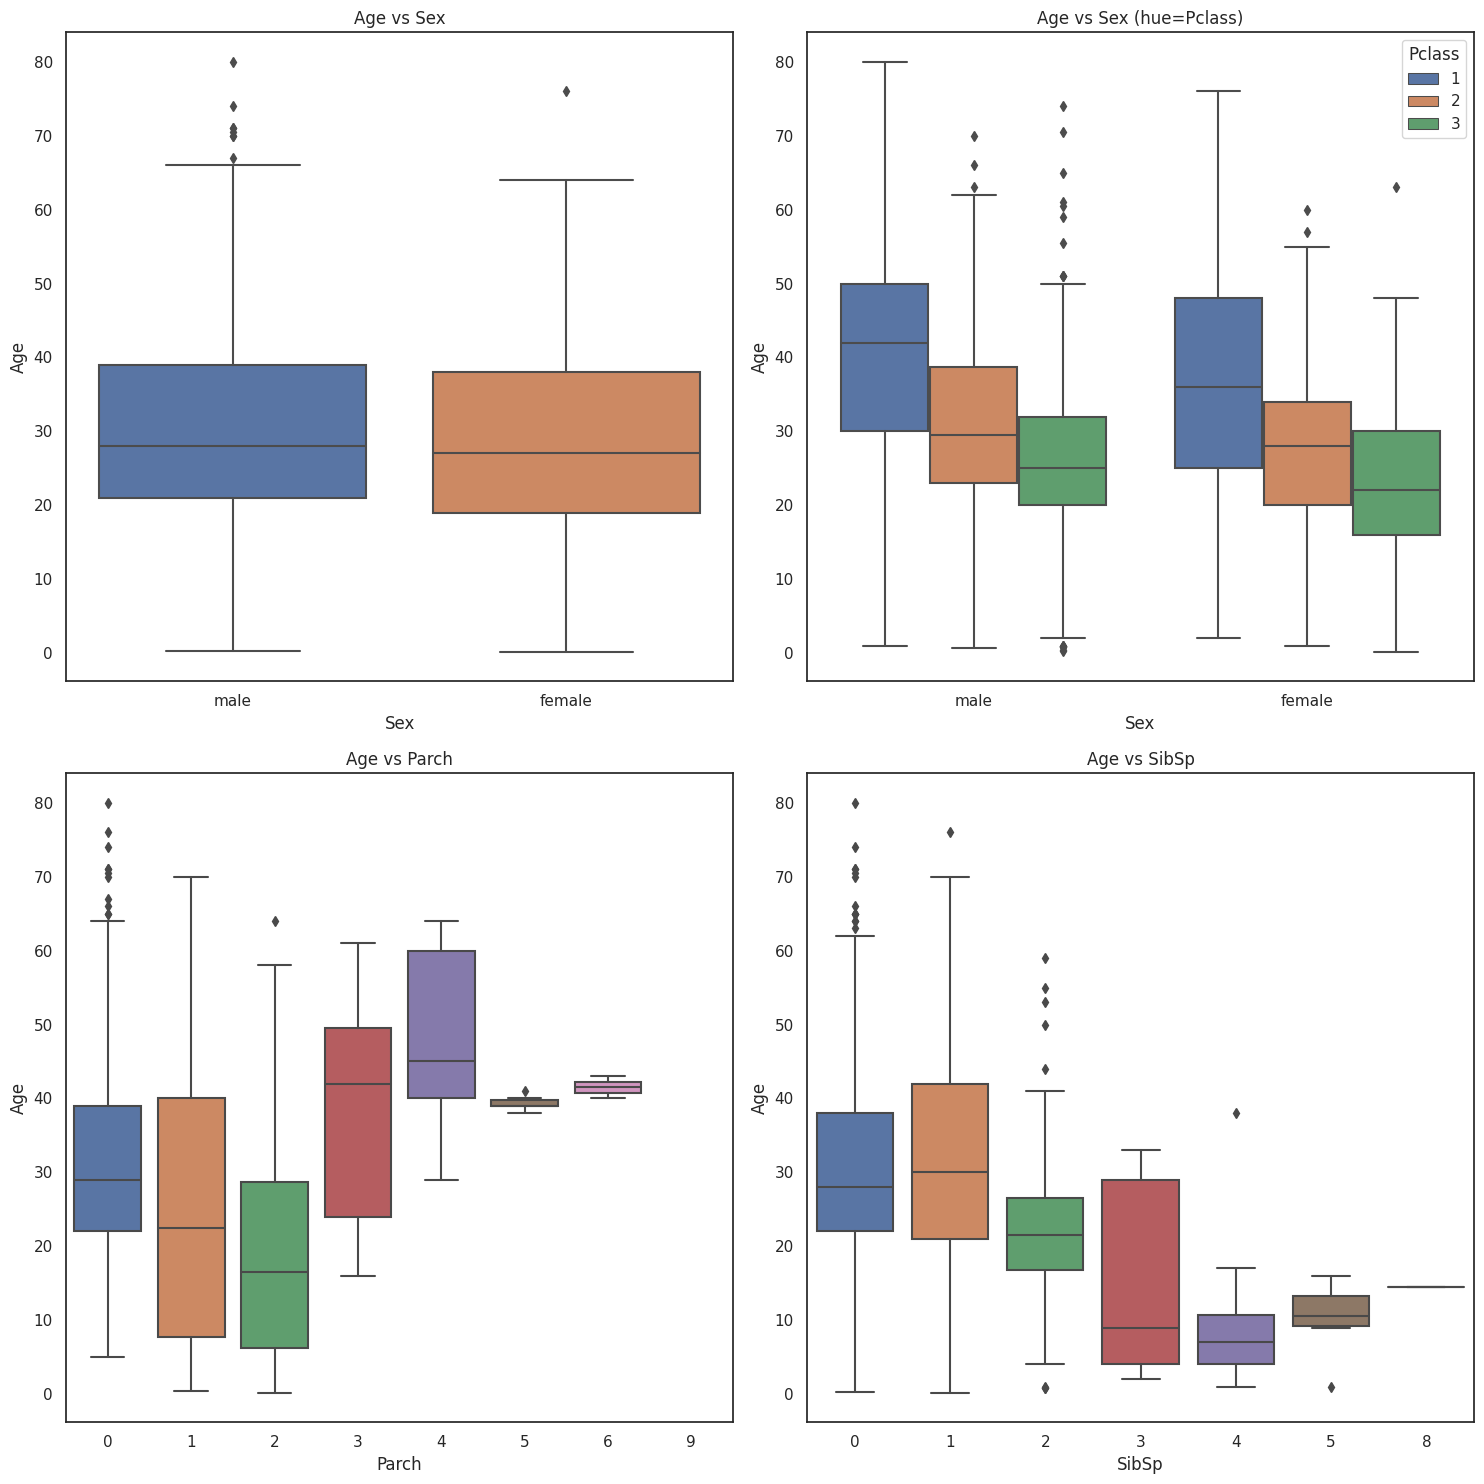

In [29]:
#Analyze the features: 'Age', 'Sex', 'Pclass', and 'SibSp'
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

sns.boxplot(y="Age", x="Sex", data=dataset, ax=axes[0, 0])
axes[0, 0].set_title('Age vs Sex')

sns.boxplot(y="Age", x="Sex", hue="Pclass", data=dataset, ax=axes[0, 1])
axes[0, 1].set_title('Age vs Sex (hue=Pclass)')

sns.boxplot(y="Age", x="Parch", data=dataset, ax=axes[1, 0])
axes[1, 0].set_title('Age vs Parch')

sns.boxplot(y="Age", x="SibSp", data=dataset, ax=axes[1, 1])
axes[1, 1].set_title('Age vs SibSp')

plt.tight_layout()
plt.show()

In [30]:
#Feature egineering: covert the feature 'Sex' values from categorial values to numerical values
#Male=Sex(0), Female=Sex(1)
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

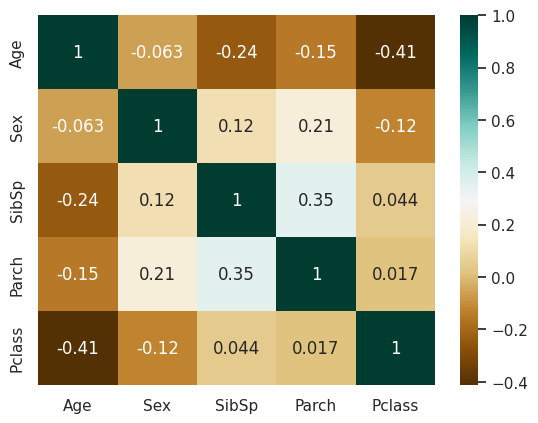

In [31]:
#Visualize the feature: 'Sex'
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

In [32]:
#'Age' does not vary proportionally with 'Parch'
#Filling the null data from 'Age'
#Find the median value of 'Age' of simialr rows according to 'Pclass', 'Parch', and 'SibSp'
index_age_null = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_age_null:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][ \
                              ((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & \
                               (dataset['Parch'] == dataset.iloc[i]['Parch']) & \
                               (dataset['Pclass'] == dataset.iloc[i]['Pclass'])) \
                             ].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

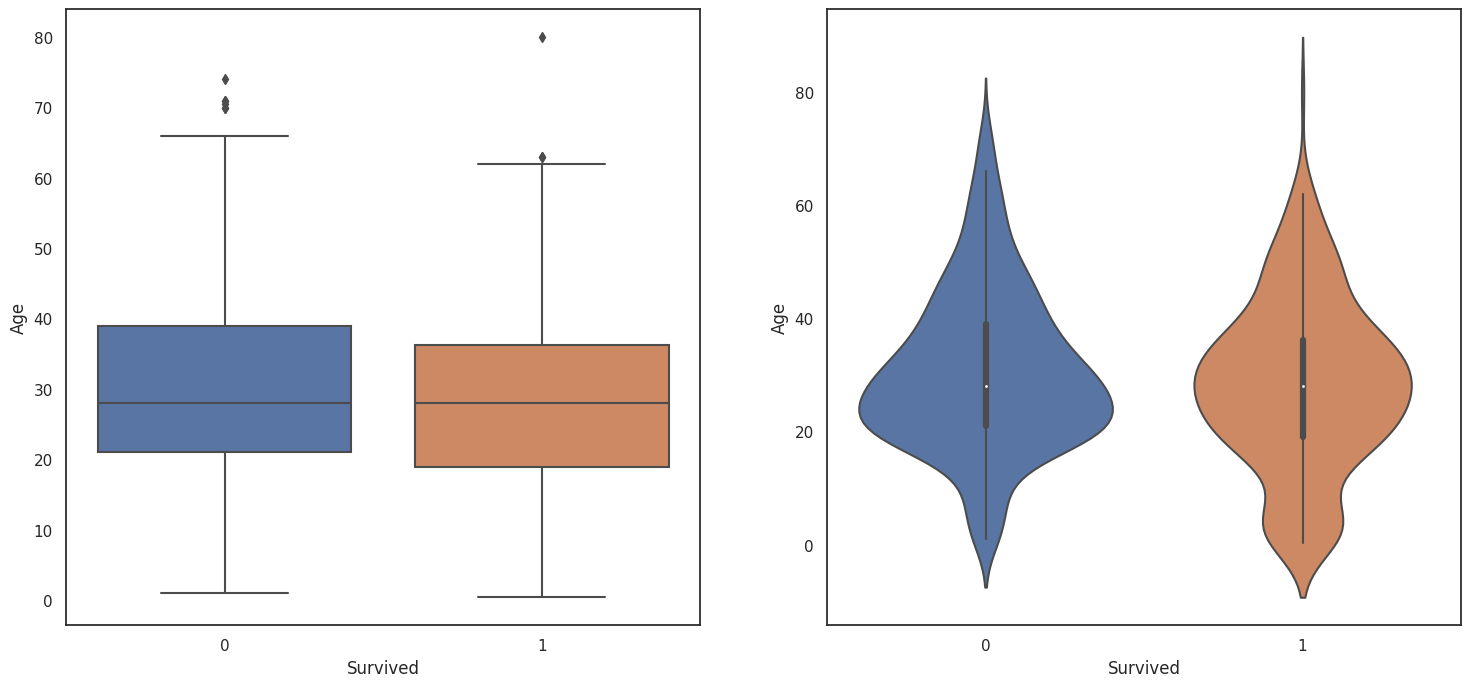

In [33]:
#Visualize the feature 'Age'
f, ax = plt.subplots(1,2,figsize=(18,8))

sns.boxplot(x='Survived', y='Age', data=train, ax=ax[0])
sns.violinplot(x='Survived', y='Age', data=train, ax=ax[1])

plt.show()

## Feature engineering

In [34]:
#Check the feature: 'Name'
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [35]:
##Feature egineering: create the feature, 'Title' <- from the categorial feature 'Name'
#Mr, Mrs, Miss, Mrs, Mr = Name[0, 1, 2, 3, 4]
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

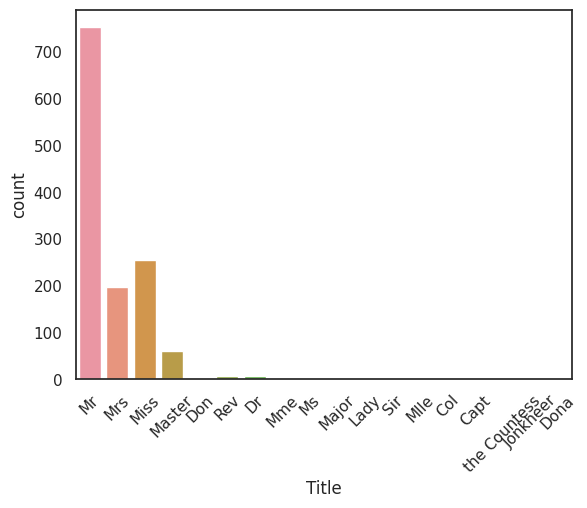

In [36]:
#Visualize the feature: 'Title'
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [37]:
#Feature engineering: convert the categorical feature 'Title' to numerical feature
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

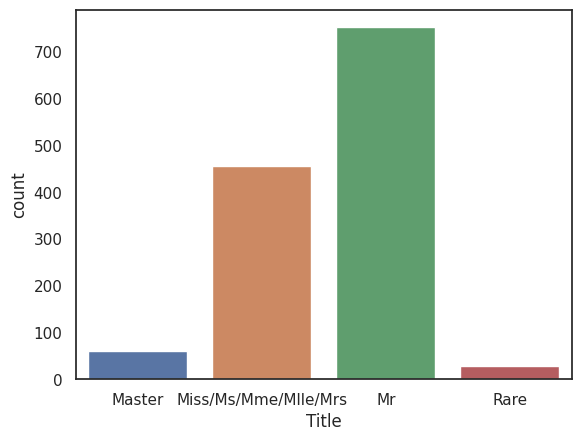

In [38]:
#Visualize the new feature 'Title'
g = sns.countplot(x=dataset['Title'])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

Text(0, 0.5, 'survival probability')

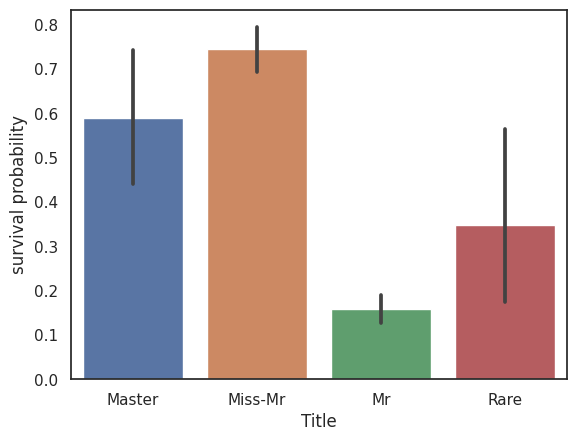

In [39]:
#Visualize the feature 'Title' in relation to the target label 'Survived'
g = sns.barplot(x='Title', y='Survived', data=dataset)
g.set_xticklabels(["Master", "Miss-Mr", "Mr", "Rare"])
g.set_ylabel('survival probability')

In [40]:
#Feature engineering: drop the feature 'Name'
dataset.drop(labels=['Name'], axis=1, inplace=True)

In [41]:
#Feature engineering: merge two features 'SibSp' and 'Parch' to 'Fsize'(family size)
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1#myself

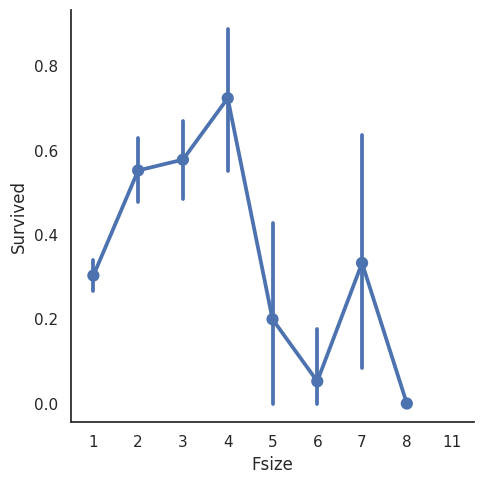

In [42]:
#Visualize the feature 'Fsize' in relation to the target label 'Survived'
g = sns.catplot(x='Fsize', y='Survived', data=dataset, kind='point')

In [43]:
#Feature engineering: divide the feature 'Fsize' into four groups
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF']   = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

Text(0, 0.5, 'Survived Probability')

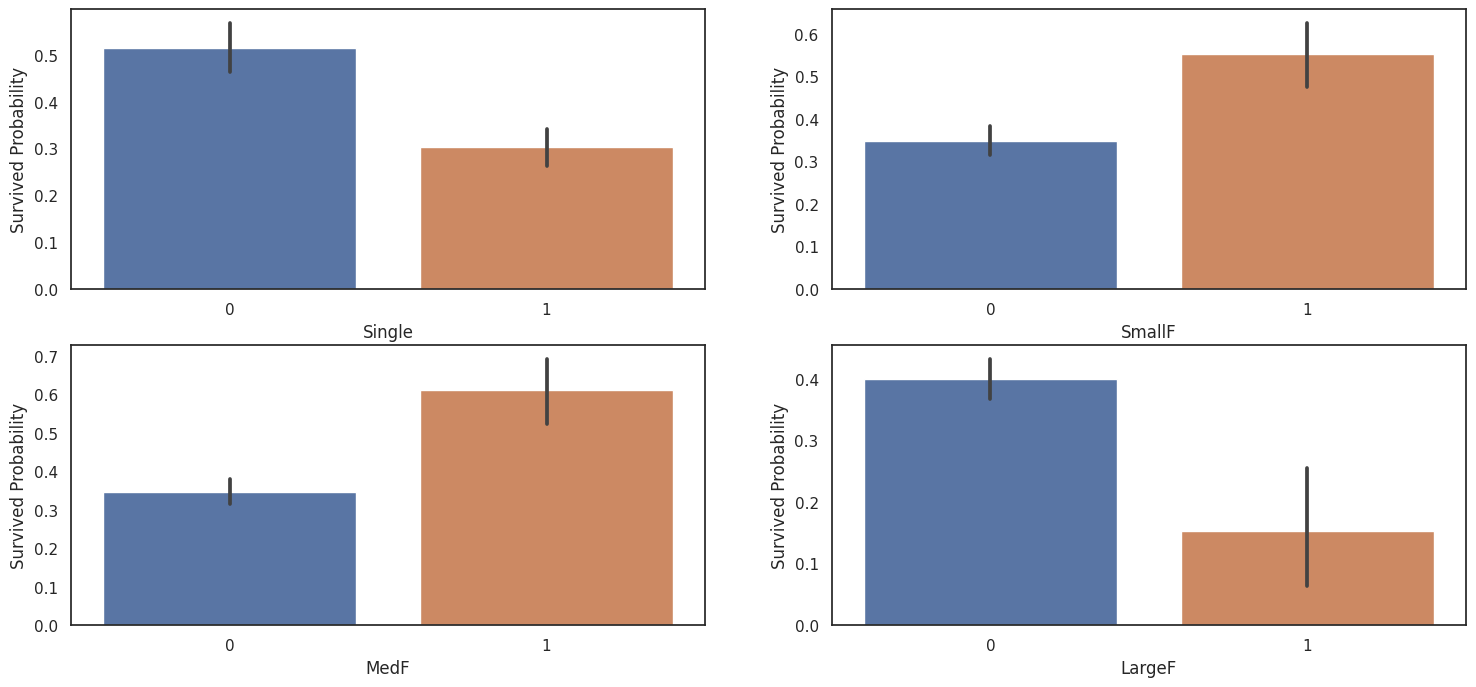

In [44]:
#Visualize the new four features in relation to the target label 'Survived'
f, ax = plt.subplots(2,2, figsize=(18,8))

g = sns.barplot(x='Single', y='Survived', data=dataset, ax=ax[0,0])
g.set_ylabel('Survived Probability')

g = sns.barplot(x='SmallF', y='Survived', data=dataset, ax=ax[0,1])
g.set_ylabel('Survived Probability')

g = sns.barplot(x='MedF', y='Survived', data=dataset, ax=ax[1,0])
g.set_ylabel('Survived Probability')

g = sns.barplot(x='LargeF', y='Survived', data=dataset, ax=ax[1,1])
g.set_ylabel('Survived Probability')

In [45]:
#Convert the categorial features, 'Title' and 'Embarked' into binary feature
#One-hot encoding
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

In [46]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,False,False,True,False,False,False,True
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,False,True,False,False,True,False,False
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,False,True,False,False,False,False,True
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,False,True,False,False,False,False,True
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,False,False,True,False,False,False,True


In [47]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [48]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [49]:
dataset['Cabin'].isnull().sum()

1007

In [50]:
#Check the feature 'Cabin'
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [51]:
#Replace the Cabin number by the type of cabin 'X' if not
cabin_letters=list()
for cabin in dataset['Cabin']:
    if pd.isnull(cabin):
        cabin_letters.append('X')
    else:
        cabin_letters.append(cabin[0])

dataset['Cabin'] = pd.Series(cabin_letters)

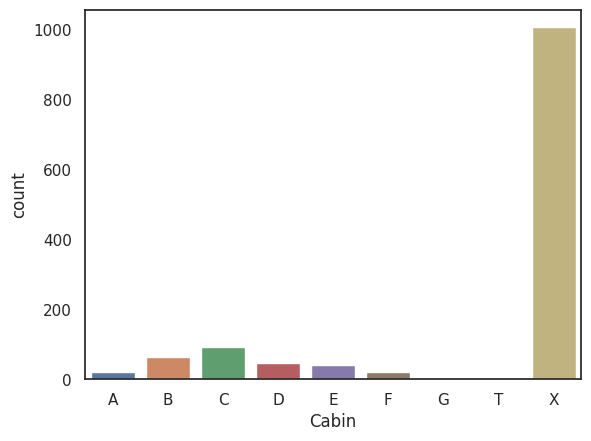

In [52]:
#Visualize the feautre 'Cabin'
g = sns.countplot(x='Cabin', data=dataset, order=['A','B','C','D','E','F','G','T','X'])

Text(0, 0.5, 'Survival Probability')

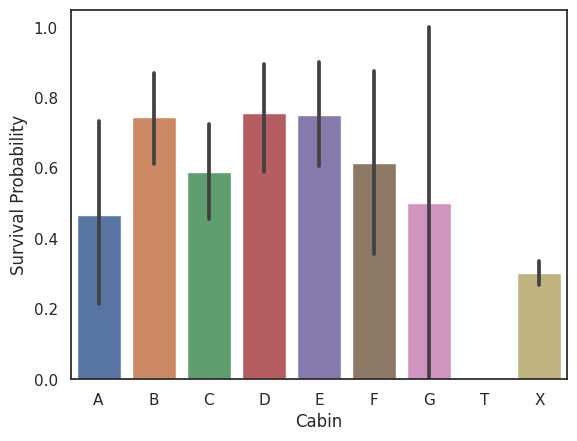

In [53]:
#Visualize the feautre 'Cabin' in relation to the target label 'Survived'
g = sns.barplot(x='Cabin', y='Survived', data=dataset, order=['A','B','C','D','E','F','G','T','X'])
g.set_ylabel('Survival Probability')

In [54]:
#Feature engineering: convert the categorial feature 'Cabin' to several binary features
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

In [55]:
#Check the feature 'Ticket'
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [56]:
#Extract the prefix of 'Ticket'. When there is no prefix, return X
ticket=list()
for t in list(dataset.Ticket):
    if not t.isdigit():
        ticket.append(t.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        ticket.append('X')

dataset['Ticket'] = ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [57]:
#Feature engineerng: convert the categorial feature 'Ticket' to several binary features
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [58]:
#Feature engineerng: convert the categorial feature 'Pclass' to several binary features
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [59]:
#Feature engineering: drop the feature 'PassengerId' 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [60]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,False,False,False,False,False,False,False,False,False,True
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,False,False,False,False,False,False,False,True,False,False
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,False,True,False,False,False,False,False,False,False,True
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,False,False,False,False,False,False,True,True,False,False
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,False,False,False,False,False,False,True,False,False,True


## Modeling

In [61]:
#Seperate train dataset and test dataset
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

In [62]:
#Separate train features and label 
train["Survived"] = train["Survived"].astype(int)
Y_train = train["Survived"]
X_train = train.drop(labels = ["Survived"], axis = 1)

In [63]:
#Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [64]:
#Modeling
random_state=2
classifiers=list()
classifiers.append(SVC(random_state=random_state)) #SVC
classifiers.append(DecisionTreeClassifier(random_state=random_state)) #Decision Tree
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), \
                                      random_state=random_state, \
                                      learning_rate=0.1)) #AdaBoost
classifiers.append(RandomForestClassifier(random_state=random_state)) #Random Forest
classifiers.append(ExtraTreesClassifier(random_state=random_state)) #Extra Trees
classifiers.append(GradientBoostingClassifier(random_state=random_state)) #Gradient Boosting
classifiers.append(MLPClassifier(random_state=random_state)) #Multiple layer perceptron (neural network)
classifiers.append(KNeighborsClassifier()) #KNN
classifiers.append(LogisticRegression(random_state = random_state)) #Logistic regression
classifiers.append(LinearDiscriminantAnalysis()) #Linear Discriminant Analysis

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Text(0.5, 1.0, 'Crosss validation scores')

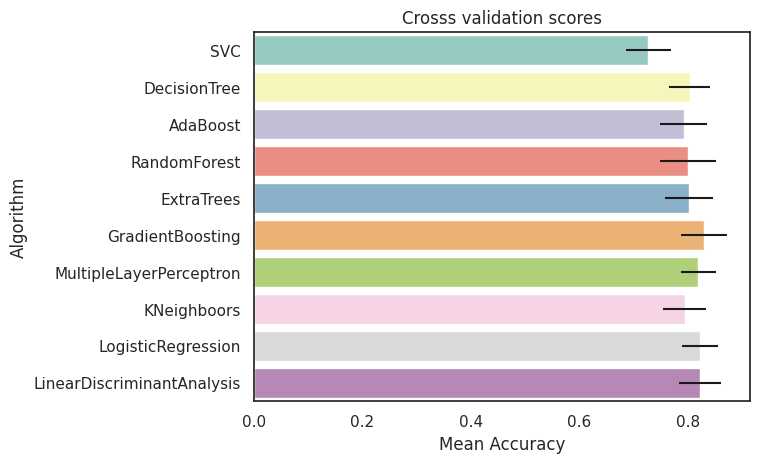

In [65]:
#Modeling
cv_results = list()
for classifier  in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, \
                                       y=Y_train, \
                                       scoring='accuracy', \
                                       cv=kfold, n_jobs=4)) #4cpu
cv_means=list()
cv_std=list()
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans": cv_means,\
                       "CrossValerrors": cv_std, \
                       "Algorithm": ["SVC","DecisionTree","AdaBoost","RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot(x='CrossValMeans', y='Algorithm', data=cv_res, palette='Set3', orient='h', xerr=cv_std)
g.set_xlabel('Mean Accuracy')
g.set_title('Crosss validation scores')

### decided to choose the SVC, AdaBoost, RandomForest, ExtraTrees and GradientBoosting classifiers for the ensemble modeling.

In [66]:
#Optimize the models: AdaBoost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {'estimator__criterion': ['gini', 'entropy'], \
                  'estimator__splitter': ['best', 'random'], \
                  'algorithm': ['SAMME','SAMME.R'], \
                  'n_estimators': [1, 2], \
                  'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC, \
                        param_grid = ada_param_grid, \
                        cv=kfold, \
                        scoring='accuracy', \
                        n_jobs= 4, \
                        verbose = 1)
gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [67]:
#Best score of optimized AdaBoost
gsadaDTC.best_score_

0.8275536261491316

In [68]:
#Optimize the models: ExtraTrees
ExtC = ExtraTreesClassifier()

#Search grid for the optimal parameters
ex_param_grid = {'max_depth': [None], \
                 'max_features': [1, 3, 10], \
                 'min_samples_split': [2, 3, 10], \
                 'min_samples_leaf': [1, 3, 10], \
                 'bootstrap': [False], \
                 'n_estimators' :[100,300], \
                 'criterion': ['gini']}

gsExtC = GridSearchCV(ExtC, \
                      param_grid = ex_param_grid, \
                      cv=kfold, \
                      scoring='accuracy', \
                      n_jobs= 4, \
                      verbose = 1)
gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [69]:
#Best score of optimized ExtraTrees
gsExtC.best_score_

0.8297369765066394

In [70]:
#Optimize the model: Random Forest 
RFC = RandomForestClassifier()

#Search grid for the optimal parameters
rf_param_grid = {'max_depth': [None], \
                 'max_features': [1, 3, 10], \
                 'min_samples_split': [2, 3, 10], \
                 'min_samples_leaf': [1, 3, 10], \
                 'bootstrap': [False], \
                 'n_estimators' :[100,300], \
                 'criterion': ['gini']}

gsRFC = GridSearchCV(RFC, \
                     param_grid = rf_param_grid, \
                     cv=kfold, \
                     scoring='accuracy', \
                     n_jobs=4, \
                     verbose=1)
gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [71]:
#Best score of optimized Random Forest
gsRFC.best_score_

0.8308861082737486

In [72]:
#Optimize the model: Gradient Boosting
GBC = GradientBoostingClassifier()

#grid parameter
gb_param_grid = {'loss': ['log_loss'], \
                 'n_estimators': [100, 200, 300], \
                 'learning_rate': [0.1, 0.05, 0.01], \
                 'max_depth': [4, 8], \
                 'min_samples_leaf': [100, 150], \
                 'max_features': [0.3, 0.1]}

gsGBC = GridSearchCV(GBC, \
                     param_grid=gb_param_grid, \
                     cv=kfold, \
                     scoring='accuracy', \
                     n_jobs=4, \
                     verbose=1)

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


In [73]:
#Best score of optimized Gradient Boosting
gsGBC.best_score_

0.8320097037793668

In [74]:
#Optimize the model: SVC
SVMC = SVC(probability=True)

svc_param_grid = {'kernel': ['rbf'], \
                  'gamma': [0.001, 0.01, 0.1, 1], \
                  'C': [1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC, \
                     param_grid=svc_param_grid, \
                     cv=kfold, \
                     scoring='accuracy', \
                     n_jobs=4, \
                     verbose=1)
gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


In [75]:
#Best score of optimized SVC
gsSVMC.best_score_

0.8331332992849847

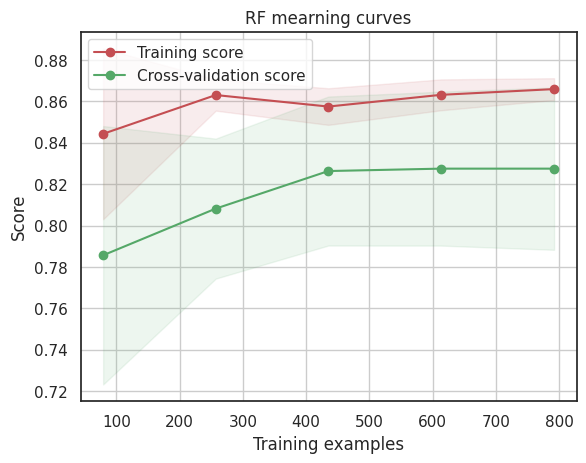

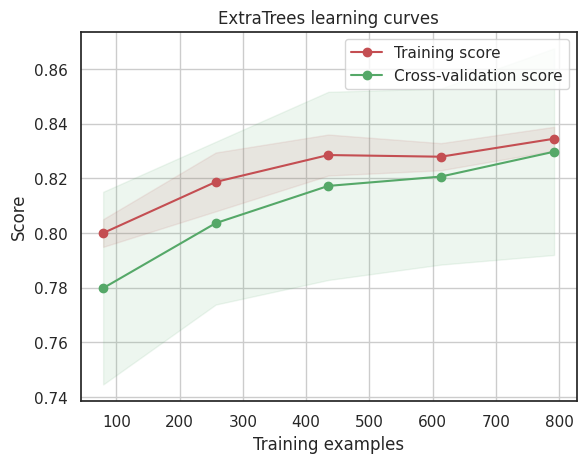

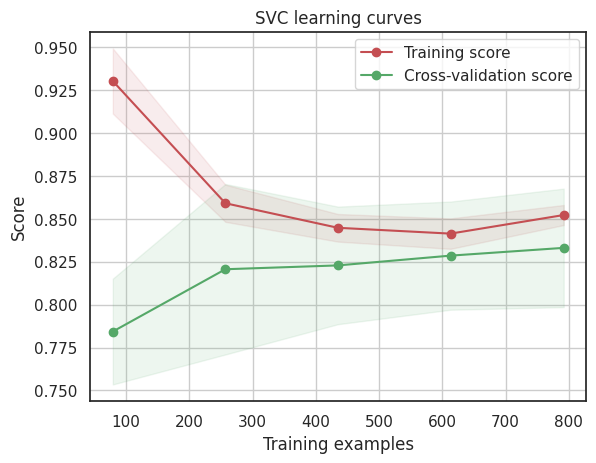

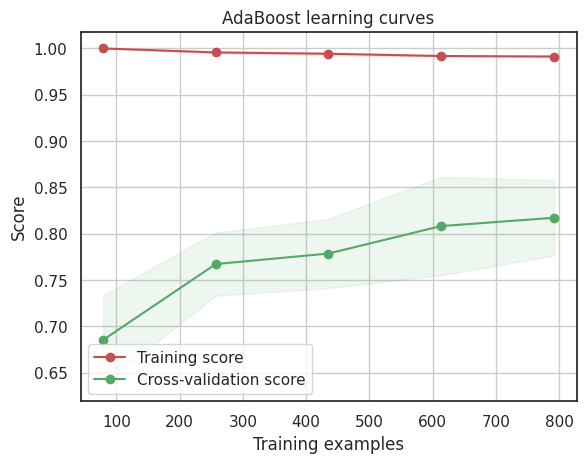

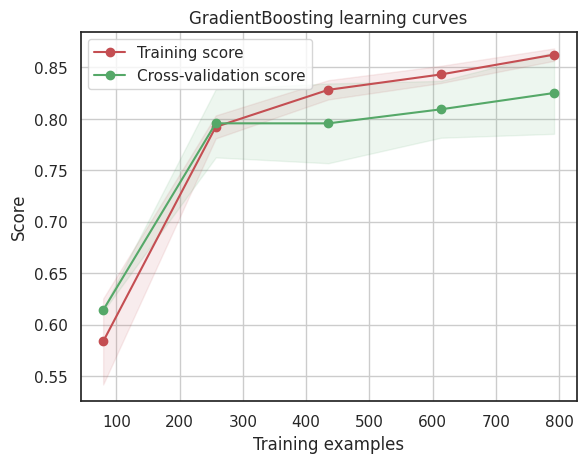

In [76]:
#Visualize the learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve
    """
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

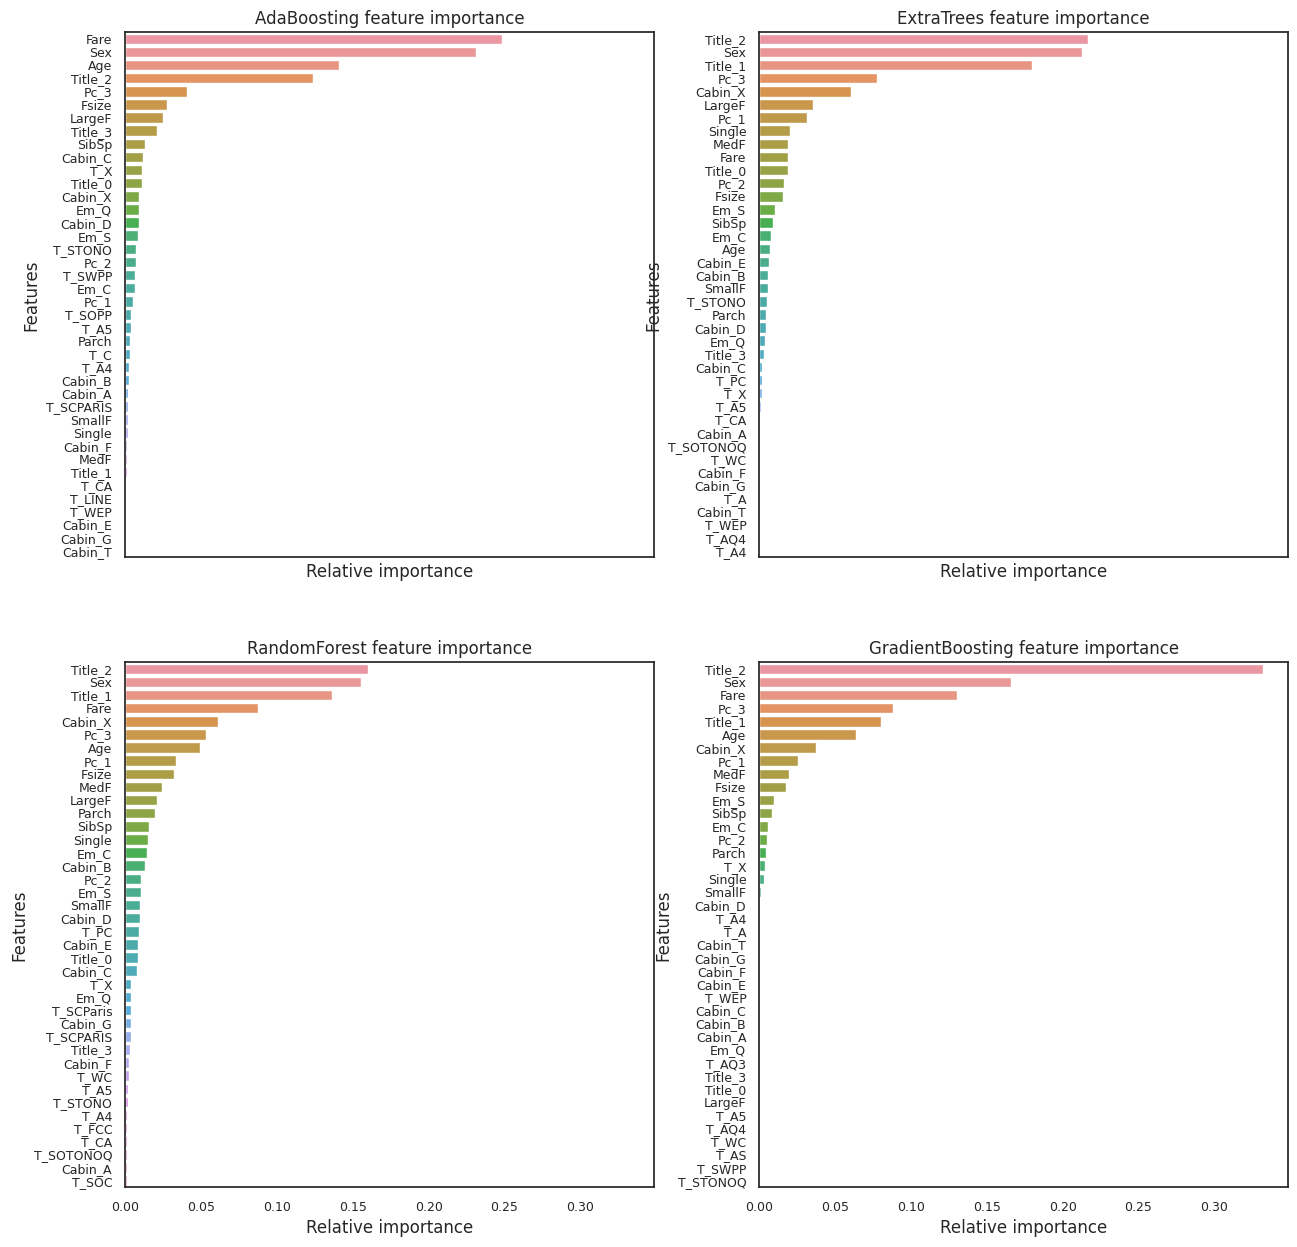

In [77]:
#Visualize the feature's importance
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best), \
                     ("ExtraTrees", ExtC_best), \
                     ("RandomForest", RFC_best),\
                      ("GradientBoosting", GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        
        g = sns.barplot(y=X_train.columns[indices][:40], x = classifier.feature_importances_[indices][:40] , orient='h', ax=axes[row][col])
        g.set_xlabel("Relative importance", fontsize=12)
        g.set_ylabel("Features", fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        
        nclassifier += 1

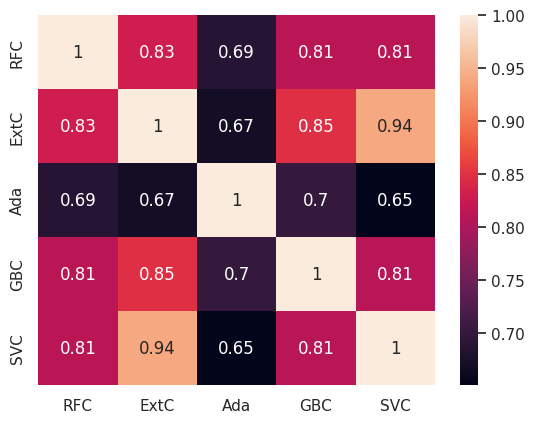

In [78]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

ensemble_results = pd.concat([test_Survived_RFC, \
                              test_Survived_ExtC, \
                              test_Survived_AdaC, \
                              test_Survived_GBC, \
                              test_Survived_SVMC],\
                            axis=1)

g= sns.heatmap(ensemble_results.corr(), annot=True)

In [79]:
#Combine the predictions: Voting classifier
votingC = VotingClassifier(estimators=[('rfc', RFC_best), \
                                       ('extc', ExtC_best), \
                                       ('svc', SVMC_best), \
                                       ('adac',ada_best), \
                                       ('gbc',GBC_best)], \
                           voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [80]:
#Prediction result
test_Survived = pd.Series(votingC.predict(test), name="Survived")
results = pd.concat([IDtest,test_Survived], axis=1)
results.to_csv("ensemble_python_voting.csv", index=False)